In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

sns.set(style="whitegrid", context="notebook")
%matplotlib inline


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Excelr/Assignments/DataSets/diabetes.csv")
print("Shape:", df.shape)
df


Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [6]:
NUM_COLS = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']


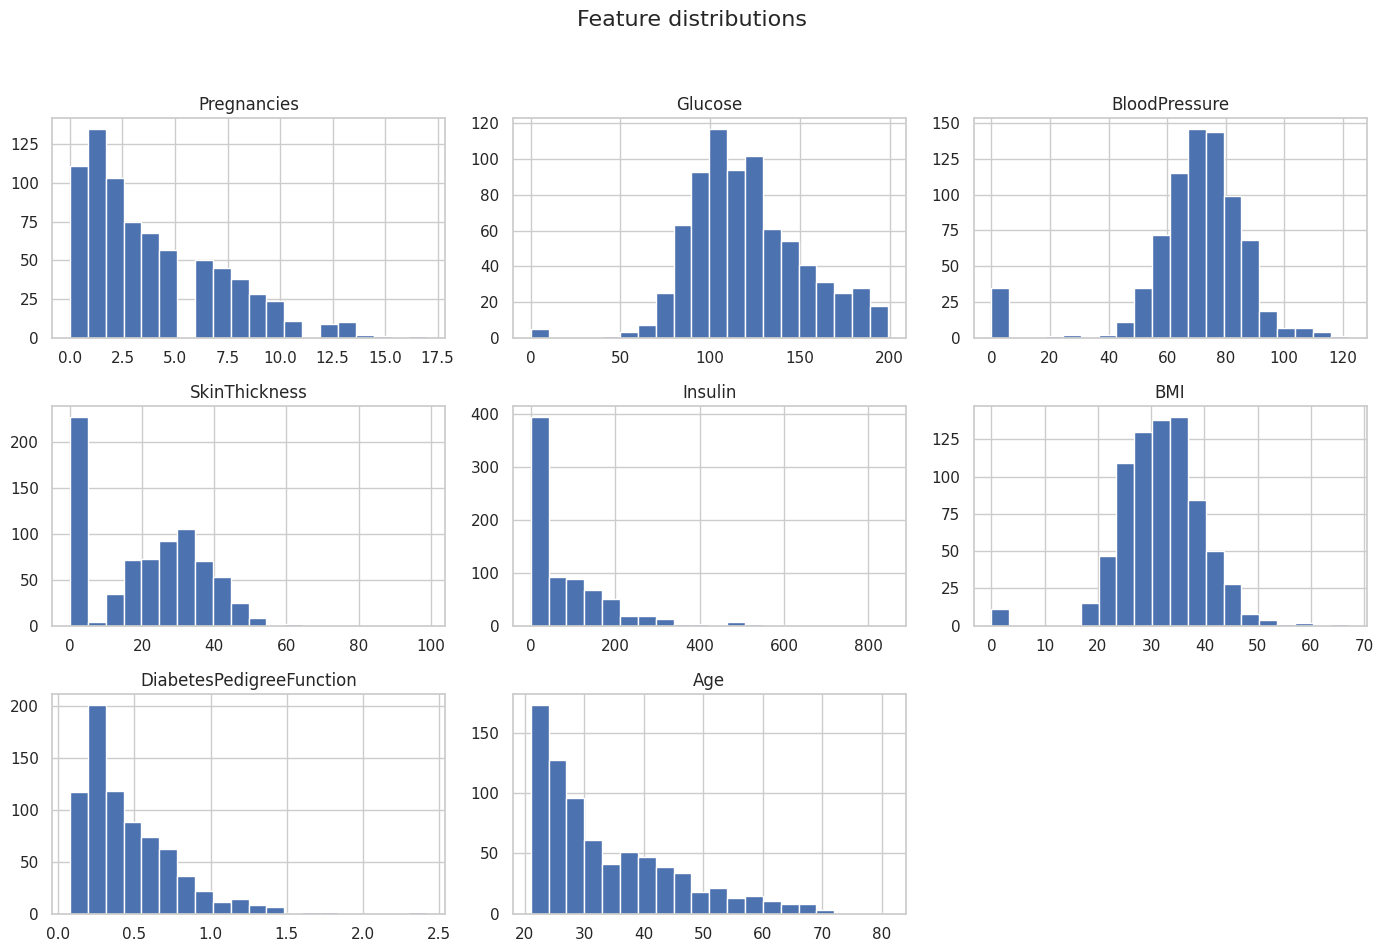

In [7]:
# Histograms for each numeric column
df[NUM_COLS].hist(bins=20, figsize=(14,10))
plt.suptitle('Feature distributions', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


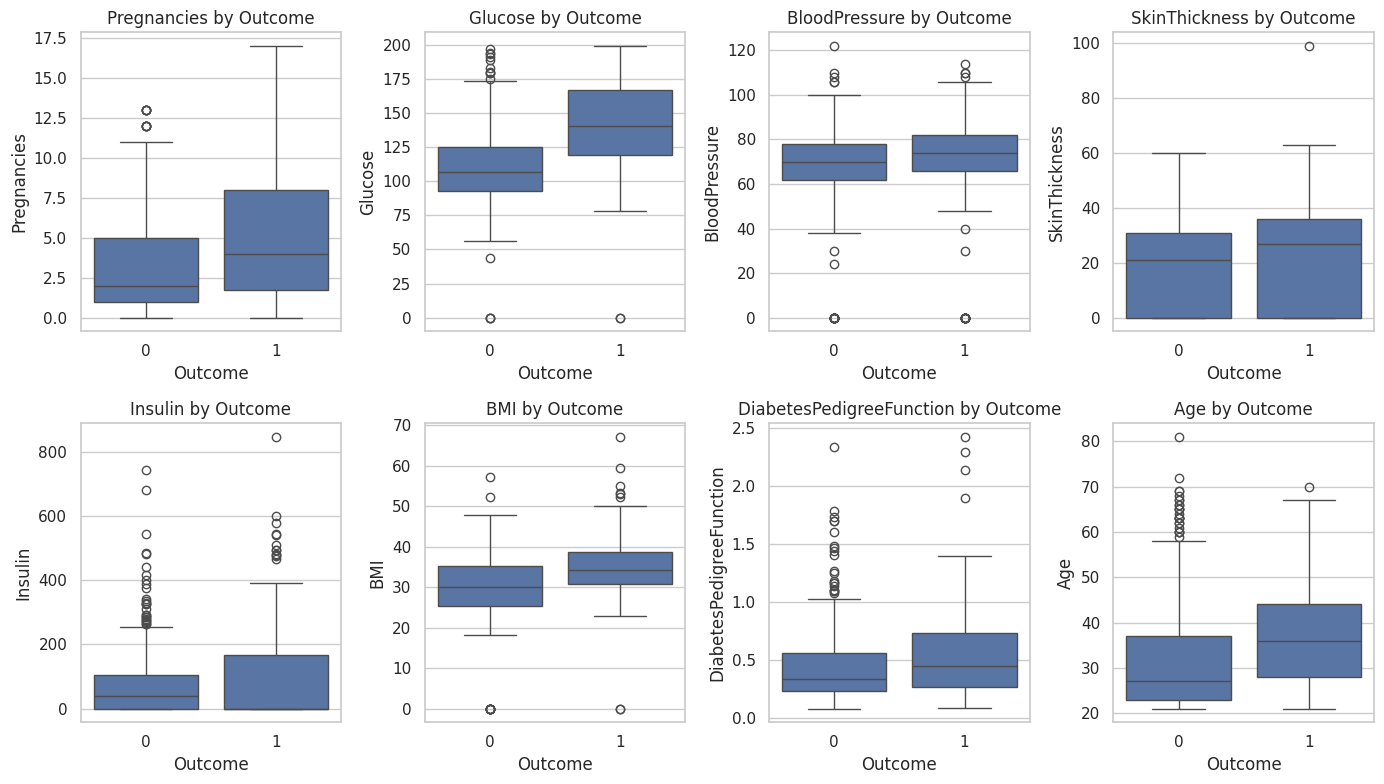

In [8]:
# Boxplots to show outliers
plt.figure(figsize=(14,8))
for i, col in enumerate(NUM_COLS):
    plt.subplot(2,4,i+1)
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.title(f"{col} by Outcome")
plt.tight_layout()
plt.show()



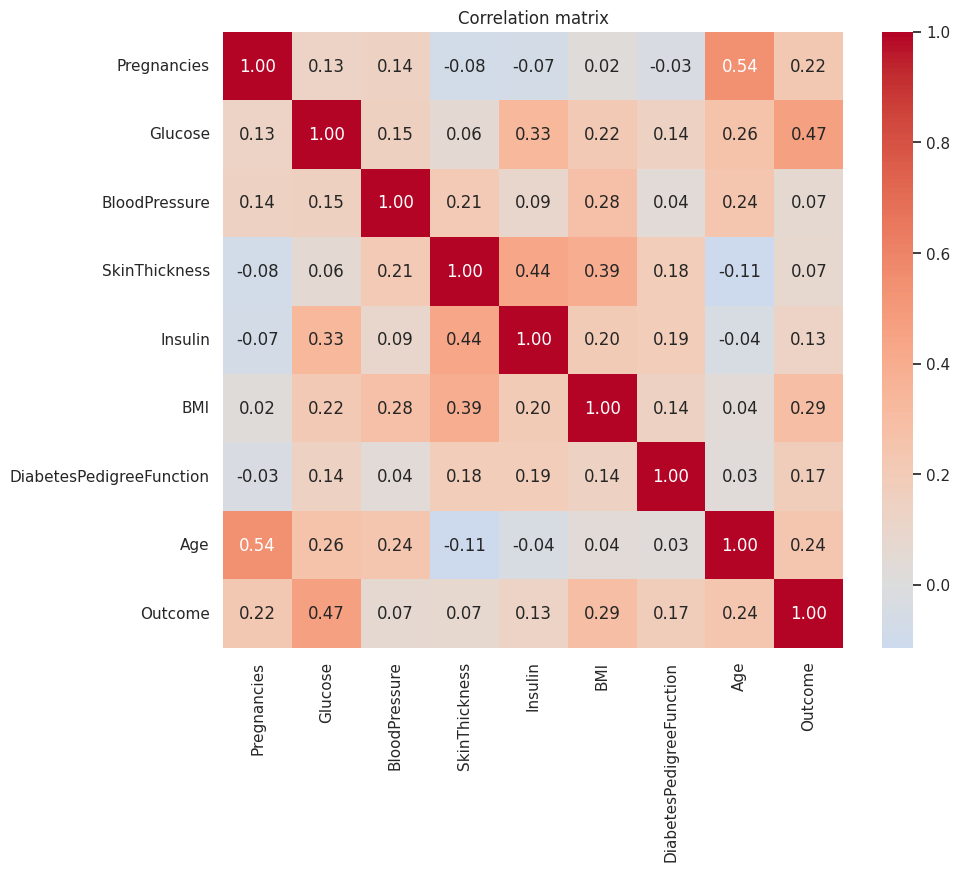

In [9]:
# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation matrix")
plt.show()


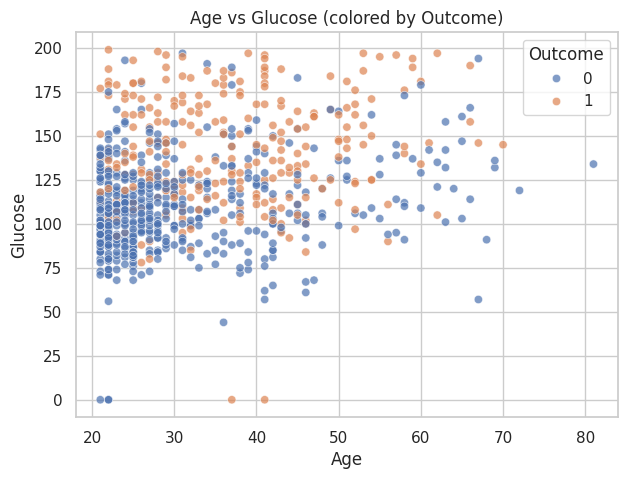

In [10]:
# Relationship: Glucose vs Age colored by Outcome scatter plot
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='Age', y='Glucose', hue='Outcome', alpha=0.7)
plt.title('Age vs Glucose (colored by Outcome)')
plt.show()

 - Replace zeros with NaN for features where 0 is invalid.
 - Impute missing values .
 - Split dataset into train/test

In [11]:
# Columns where zero should be considered missing
cols_zero_missing = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']


In [12]:
# Replace zeros with NaN in those columns
df[cols_zero_missing] = df[cols_zero_missing].replace(0, np.nan)



In [13]:
# Show counts of missing now
print("Missing counts after zero->NaN replacement:")
print(df.isnull().sum())


Missing counts after zero->NaN replacement:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [14]:
# Separate X and y
X = df.drop(columns=['Outcome'])
y = df['Outcome']


In [15]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47


In [16]:
y

,Outcome
0,1
1,0
2,1
3,0
4,1
...,...
763,0
764,0
765,0
766,1


In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (614, 8) Test shape: (154, 8)


In [18]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

In [19]:
# Fit the imputer on training data and transform both train and test
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imputed  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

In [20]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_imputed.columns, index=X_train_imputed.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test_imputed.columns, index=X_test_imputed.index)


In [21]:
# Use the non-scaled imputed data for tree-based models
X_train_ready = X_train_imputed.copy()
X_test_ready = X_test_imputed.copy()

In [22]:
# Common CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [23]:
# Function to run grid search for a model
def run_grid_search(model, param_grid, X, y, cv=cv, scoring='roc_auc', verbose=1):
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=verbose,
        return_train_score=True
    )
    grid.fit(X, y)
    return grid


In [24]:
# XGBoost param grid
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [25]:
# LightGBM param grid
lgb = LGBMClassifier(random_state=42)
lgb_param_grid = {
    'n_estimators': [100, 200],
    'num_leaves': [15, 31],
    'max_depth': [ -1, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}



In [26]:
# Run grid search for XGBoost
print("Tuning XGBoost...")
xgb_grid = run_grid_search(xgb, xgb_param_grid, X_train_ready, y_train, verbose=2)
print("Best XGBoost params:", xgb_grid.best_params_)
print("Best CV ROC AUC (XGB):", xgb_grid.best_score_)


Tuning XGBoost...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:53:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV ROC AUC (XGB): 0.8358236434108527


In [27]:
# Run grid search for LightGBM
print("\nTuning LightGBM...")
lgb_grid = run_grid_search(lgb, lgb_param_grid, X_train_ready, y_train, verbose=2)
print("Best LightGBM params:", lgb_grid.best_params_)
print("Best CV ROC AUC (LGB):", lgb_grid.best_score_)



Tuning LightGBM...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
Best LightGBM params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 15, 'subsample': 0.8}
Best CV ROC AUC (LGB): 0.8290199335548172


In [28]:
# 6) Evaluate best estimators on the test set
best_xgb = xgb_grid.best_estimator_
best_lgb = lgb_grid.best_estimator_


In [29]:

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"--- {name} ---")
    print("Accuracy:", round(acc,4))
    print("Precision:", round(prec,4))
    print("Recall:", round(rec,4))
    print("F1-score:", round(f1,4))
    print("ROC AUC:", round(auc,4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return {'model': name, 'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'roc_auc':auc, 'y_pred':y_pred, 'y_prob':y_prob}




In [30]:
res_xgb = evaluate_model(best_xgb, X_test_ready, y_test, name="XGBoost (best)")


--- XGBoost (best) ---
Accuracy: 0.7273
Precision: 0.65
Recall: 0.4815
F1-score: 0.5532
ROC AUC: 0.8187

Classification Report:
               precision    recall  f1-score   support

           0     0.7544    0.8600    0.8037       100
           1     0.6500    0.4815    0.5532        54

    accuracy                         0.7273       154
   macro avg     0.7022    0.6707    0.6785       154
weighted avg     0.7178    0.7273    0.7159       154

Confusion Matrix:
 [[86 14]
 [28 26]]


In [31]:
res_lgb = evaluate_model(best_lgb, X_test_ready, y_test, name="LightGBM (best)")

--- LightGBM (best) ---
Accuracy: 0.7662
Precision: 0.6957
Recall: 0.5926
F1-score: 0.64
ROC AUC: 0.8294

Classification Report:
               precision    recall  f1-score   support

           0     0.7963    0.8600    0.8269       100
           1     0.6957    0.5926    0.6400        54

    accuracy                         0.7662       154
   macro avg     0.7460    0.7263    0.7335       154
weighted avg     0.7610    0.7662    0.7614       154

Confusion Matrix:
 [[86 14]
 [22 32]]


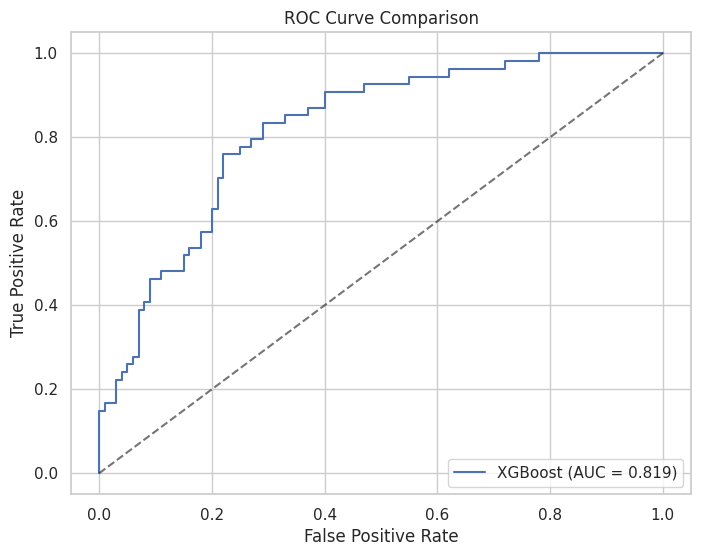

In [32]:
# 7) ROC curves for XGBoost
plt.figure(figsize=(8,6))
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, res_xgb['y_prob'])
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {res_xgb['roc_auc']:.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


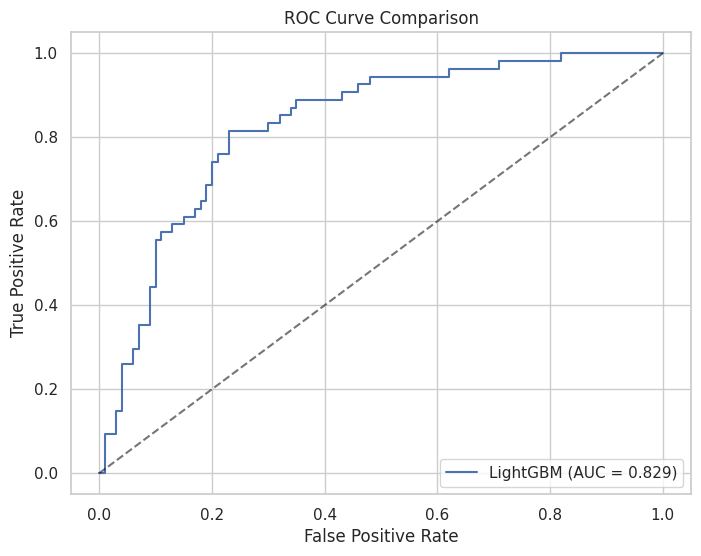

In [33]:
# 7) ROC curves for LightGBM
plt.figure(figsize=(8,6))
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, res_lgb['y_prob'])
plt.plot(fpr_lgb, tpr_lgb, label=f"LightGBM (AUC = {res_lgb['roc_auc']:.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


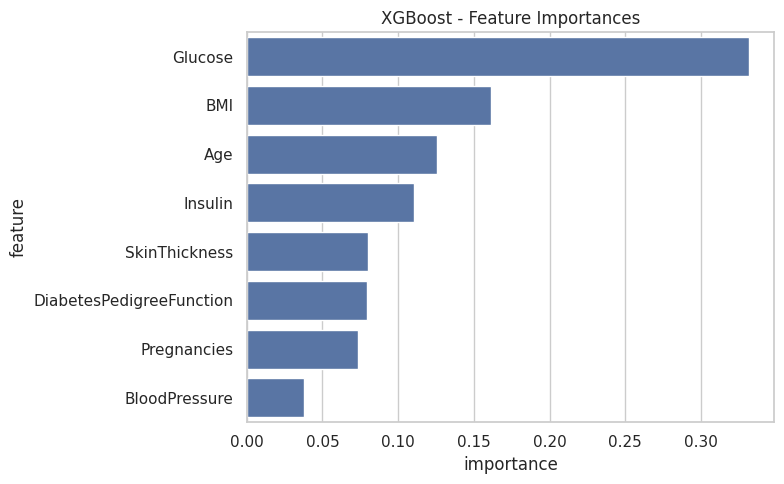

In [34]:
# Feature importance for XGBoost
def plot_feature_importances(model, X_columns, title="Feature Importances", n=10):
    imp = model.feature_importances_
    fi = pd.DataFrame({'feature': X_columns, 'importance': imp})
    fi = fi.sort_values('importance', ascending=False).head(n)
    plt.figure(figsize=(8,5))
    sns.barplot(x='importance', y='feature', data=fi)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importances(best_xgb, X_train_ready.columns, title="XGBoost - Feature Importances")



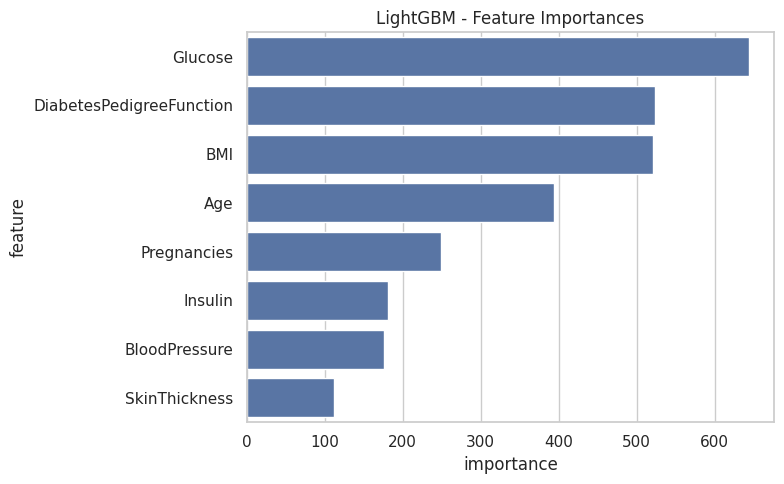

In [35]:
# Feature importance for LightGBM
def plot_feature_importances(model, X_columns, title="Feature Importances", n=10):

    imp = model.feature_importances_
    fi = pd.DataFrame({'feature': X_columns, 'importance': imp})
    fi = fi.sort_values('importance', ascending=False).head(n)
    plt.figure(figsize=(8,5))
    sns.barplot(x='importance', y='feature', data=fi)
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_feature_importances(best_lgb, X_train_ready.columns, title="LightGBM - Feature Importances")


**Dataset & Preprocessing**

- Dataset size: 768 records, 8 features + 1 target (Outcome).

- Features: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age.

**Missing values handling:**

- Zeroes in [Glucose, BloodPressure, SkinThickness, Insulin, BMI] treated as missing.

- Median imputation applied.

**Train/Test split: 80/20 **

**Best Hyperparameters (from GridSearchCV)**

**XGBoost**

{'colsample_bytree': 0.8,

 'learning_rate': 0.01,

 'max_depth': 3,

 'n_estimators': 200,

 'subsample': 0.8}



**LightGBM**

{'colsample_bytree': 1.0,

 'learning_rate': 0.01,

 'max_depth': -1,

 'n_estimators': 200,

 'num_leaves': 15,

 'subsample': 0.8}


**Test Set Performance**

| Model    | Accuracy | Precision | Recall | F1-score | ROC AUC |
| -------- | -------- | --------- | ------ | -------- | ------- |
| XGBoost  | 0.727    | 0.650     | 0.482  | 0.553    | 0.819   |
| LightGBM | 0.766    | 0.696     | 0.593  | 0.640    | 0.829   |


**Accuracy & F1-score:**

- LightGBM performed better (Accuracy: 0.766 vs 0.727, F1: 0.64 vs 0.55).

- Indicates better balance between false positives & false negatives.

**Recall:**

- LightGBM (0.593) > XGBoost (0.482).



**Precision:**

- LightGBM again leads (0.696 vs 0.650).



**ROC AUC:**

- LightGBM slightly higher (0.829 vs 0.819).



**Confusion Matrix insights:**

- XGBoost correctly detected 26 diabetics, missed 28.

- LightGBM correctly detected 32 diabetics, missed 22 (better recall).